In [1]:
import csv
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
import sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
ch, row, col = 3, 160, 320  # Image format

In [3]:
def crop_resize(image):
    # TODO: create a function that will take the image in crop and resize
    # Crop top and bottom 
    shape = image.shape
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    # Resize to (64, 64) as shown by NVIDIA model
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    return image

In [4]:
def flip_vertical(image, angle):
    """
    Flips images and angle on a vertical line
    i.e right(+1) becomes left(-1)
    """
    flip_image = cv2.flip(image, 1)
    flip_angle = angle * (-1.0)
    return (flip_image, flip_angle)

In [5]:
def img_to_YUV(img):
    """ Converted Image from BGR to RGB """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return img

In [6]:
def aug_brightness(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image[:,:,2] = image[:,:,2]*random_bright
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

In [7]:
def preprocess(image, angle):
    rand_flip = np.random.randint(2)
    image = aug_brightness(image)
    if rand_flip == 1:
        image, angle = flip_vertical(image, angle)
    image = crop_resize(image)
    return image, angle
np.random.randint(2)

1

In [45]:
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if abs(float(line[3])) < 0.05 and np.random.uniform() < 1:
            continue
        samples.append(line)

In [46]:
print(len(samples))

3155


In [47]:
lines = []
for line in range(len(samples)):
    lines.append(float(samples[line][3]))

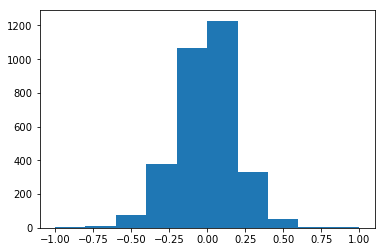

In [48]:
plt.hist(lines, bins=10, range=[-1, 1])
plt.show()

In [12]:
print(len(samples))

3675


0.3647059
<class 'float'>


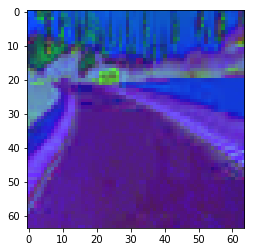

-0.3647059


In [132]:
whichline = 3500
filename = samples[whichline][0].split('/')[-1]
current_path = "./data/IMG/{}".format(filename)
steering = float(samples[whichline][3])
print(steering)
print(type(steering))
img = img_to_YUV(cv2.imread(current_path))
img = crop_resize(img)
img, steering = flip_vertical(img, steering)
plt.imshow(img)
plt.show()
print(steering)

In [133]:
whichline = 3500
filename = samples[whichline][0].split('/')[-1]
current_path = "./data/IMG/{}".format(filename)
steering = float(samples[whichline][3])
print(steering)

0.3647059


0.3647059
<class 'float'>


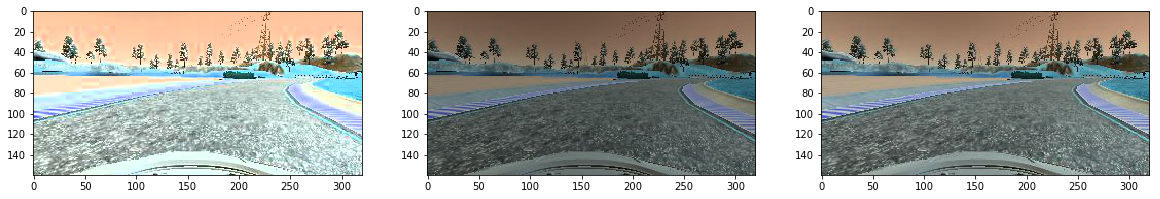

In [134]:
whichline = 3500
filename = samples[whichline][0].split('/')[-1]
current_path = "./data/IMG/{}".format(filename)
steering = float(samples[whichline][3])
print(steering)
print(type(steering))
plt.figure(figsize=(20,40))
plt.subplot(1, 3, 1)
img = aug_brightness(cv2.imread(current_path))
plt.imshow(img)
plt.subplot(1, 3, 2)
img = aug_brightness(cv2.imread(current_path))
plt.imshow(img)
plt.subplot(1, 3, 3)
img = aug_brightness(cv2.imread(current_path))
plt.imshow(img)
plt.show()

In [135]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

0.3647059


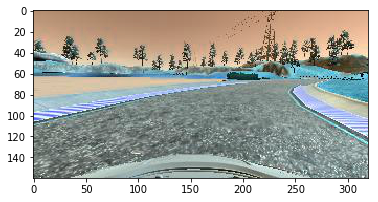

In [143]:
whichline = 3500
filename = samples[whichline][0].split('/')[-1]
current_path = "./data/IMG/{}".format(filename)
steering = float(samples[whichline][3])
print(steering)
img = cv2.imread(current_path)
img = add_random_shadow(img)
plt.imshow(img)
plt.show()

0.3647059
-0.3647059


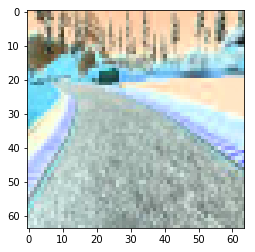

In [141]:
whichline = 3500
filename = samples[whichline][0].split('/')[-1]
current_path = "./data/IMG/{}".format(filename)
steering = float(samples[whichline][3])
print(steering)
img = cv2.imread(current_path)

img, steering = preprocess(img, steering)

print(steering)
plt.imshow(img)
plt.show()

In [7]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [8]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:  # Loop forever so the generator never terminates
            sklearn.utils.shuffle(samples)
            for offset in range(0, num_samples, batch_size):
                batch_samples = samples[offset:offset + batch_size]

                images = []
                measurements = []
                for batch_sample in batch_samples:
                    for i in range(3):
                        # Source for image (center[0], left[1], right[2])
                        filename = line[i].split('/')[-1]
                        current_path = "./data/IMG/{}".format(filename)
                        # Image Color filter
                        img = img_to_YUV(cv2.imread(current_path))
                        # Getting steering correction for images left and right
                        correction = 0.25
                        steering = float(line[3])
                        if i == 1:
                            steering = steering + correction
                        elif i == 2:
                            steering = steering - correction
                        else:
                            steering = steering
                        # Augment a flip of the image
                        aug_img, aug_steering = flip_vertical(img, steering)
                        # Append all the images and measurements
                        images.extend((img, aug_img))
                        measurements.extend((steering, aug_steering))

                X_train = np.array(images)
                y_train = np.array(measurements)
                yield sklearn.utils.shuffle(X_train, y_train)